# Load lib & data

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [300]:
# Dataset vinamilk
# vnk = pd.read_csv('vnk.csv', index_col = "Date")
# vnk

In [301]:
# Dataset vn30
vn30 = pd.read_csv('vn30index.csv', index_col = "Date")
vn30

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
11/29/2024,"1,311.26","1,301.34","1,311.67","1,298.64",136.47M,0.75%
11/28/2024,"1,301.52","1,305.79","1,310.41","1,298.43",145.66M,0.04%
11/27/2024,"1,301.06","1,297.28","1,303.99","1,296.94",113.49M,0.14%
11/26/2024,"1,299.22","1,292.84","1,304.34","1,292.27",140.91M,0.56%
11/25/2024,"1,291.94","1,286.46","1,293.30","1,285.82",139.57M,0.46%
...,...,...,...,...,...,...
01/10/2022,"1,514.70","1,531.13","1,537.71","1,514.70",200.03K,-1.14%
01/07/2022,"1,532.24","1,548.77","1,550.47","1,532.24",200.63K,-0.82%
01/06/2022,"1,544.95","1,542.34","1,554.97","1,541.19",231.96K,-0.07%


In [302]:
vn30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726 entries, 11/29/2024 to 01/04/2022
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     726 non-null    object
 1   Open      726 non-null    object
 2   High      726 non-null    object
 3   Low       726 non-null    object
 4   Vol.      725 non-null    object
 5   Change %  726 non-null    object
dtypes: object(6)
memory usage: 39.7+ KB


# Preprocessing

In [303]:
def clean_char(x):
    if isinstance(x, str):
        x = x.replace(",", "")  # Remove ","
        x = float(x)
    return x

def draw_month(df):
  plt.figure(figsize=(15, 4))
  plt.plot(df.index, df.values, marker='o', linestyle='-', color='green', label='Average Price')

  plt.title("Monthly Average Stock Price of VN30", fontsize=12)
  plt.xlabel("Month", fontsize=12)
  plt.ylabel("Average Price", fontsize=12)
  plt.xticks(df.index, df.index.strftime('%m-%Y'), rotation=30, fontsize=10)
  plt.grid(visible=True)
  plt.legend(fontsize=12)
  plt.show()

# def draw_day(real_price):
#     plt.figure(figsize=(6, 3))
#     plt.plot(real_price, color='green')

#     plt.title("Daily Average Stock Price of VN30", fontsize=10)
#     plt.xlabel("Day", fontsize=10)
#     plt.ylabel("Stock price", fontsize=10)

#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)

#     plt.legend(fontsize=10)
#     plt.show()

In [304]:
vn30.index = pd.to_datetime(vn30.index) # Convert to Data time
vn30.index = vn30.sort_index().index # Sort by ascending order
vn30 = vn30.drop(columns=["Vol.","Change %"]) # Drop columns

In [305]:
vn30 = vn30.applymap(clean_char)
vn30

<ipython-input-305-6015b8a7c951>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vn30 = vn30.applymap(clean_char)


,Price,Open,High,Low
Date,,,,
2022-01-04,1311.26,1301.34,1311.67,1298.64
2022-01-05,1301.52,1305.79,1310.41,1298.43
2022-01-06,1301.06,1297.28,1303.99,1296.94
2022-01-07,1299.22,1292.84,1304.34,1292.27
2022-01-10,1291.94,1286.46,1293.30,1285.82
...,...,...,...,...
2024-11-25,1514.70,1531.13,1537.71,1514.70
2024-11-26,1532.24,1548.77,1550.47,1532.24
2024-11-27,1544.95,1542.34,1554.97,1541.19


In [306]:
vn30.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2022-01-04 to 2024-11-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   726 non-null    float64
 1   Open    726 non-null    float64
 2   High    726 non-null    float64
 3   Low     726 non-null    float64
dtypes: float64(4)
memory usage: 28.4 KB


In [307]:
vn30.describe()

,Price,Open,High,Low
count,726.000000,726.000000,726.000000,726.000000
mean,1221.522948,1222.503058,1230.544587,1212.223264
std,142.531177,142.994558,142.726511,143.185572
min,904.770000,878.240000,927.370000,863.310000
25%,1100.527500,1099.890000,1109.485000,1091.610000
50%,1232.435000,1235.365000,1241.855000,1224.980000
75%,1302.310000,1302.852500,1310.582500,1296.317500
max,1558.870000,1561.140000,1570.320000,1552.440000


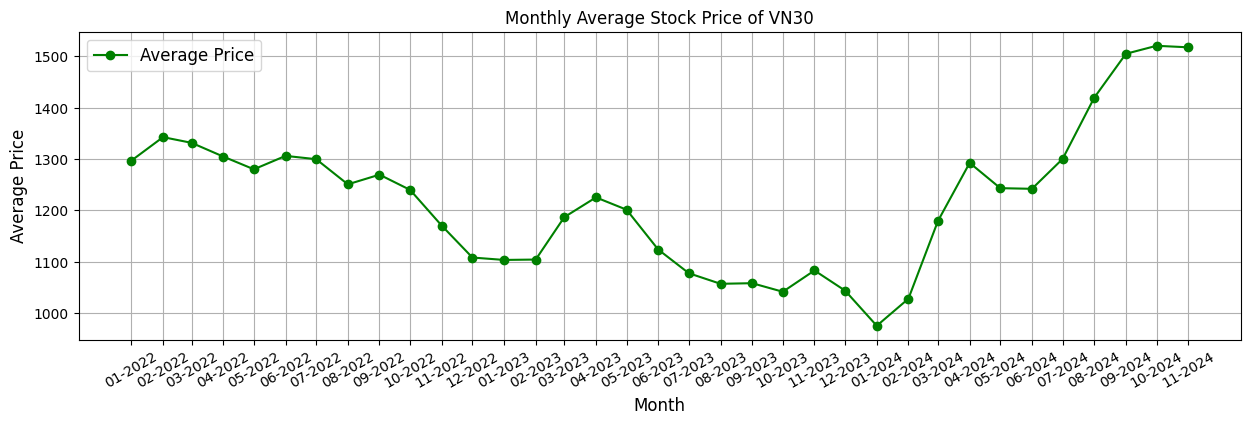

In [308]:
# Visualize on Month
vn30_month = vn30.copy().reset_index()
vn30_month['Month'] = vn30_month['Date'].dt.to_period('M')

avg = vn30_month.groupby('Month')['Price'].mean()
avg.index = avg.index.to_timestamp()
draw_month(avg)

# Model

In [309]:
def dataset(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

def create_model(hidden_size, seq_length):
    model = Sequential()
    model.add(LSTM(units=hidden_size, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(units=hidden_size, return_sequences=True))
    model.add(LSTM(units=hidden_size))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    return model

In [310]:
# Divide train, test
data = vn30[['Price']].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scale= scaler.fit_transform(data)

train_size = int(len(data_scale) * 0.8)
test_size = len(data_scale) - train_size
train_data, test_data = data_scale[:train_size, :], data_scale[train_size:len(data_scale), :]

#Time step
seq_length = 15
X_train, y_train = dataset(train_data, seq_length)
X_test, y_test = dataset(test_data, seq_length)

In [311]:
# Init param
model = create_model(64, seq_length)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                       │ (None, 15, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_70 (LSTM)                       │ (None, 15, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_71 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,009 (324.25 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

In [312]:
# Training
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0862 - val_loss: 0.0753
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0120 - val_loss: 0.0366
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0077 - val_loss: 0.0144
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0046 - val_loss: 0.0071
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0052 - val_loss: 0.0068
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0044 - val_loss: 0.0112
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

# Evaluation

In [313]:
# Calculate
def calculate_metrics(actuals, predictions):
    metrics = {}

    # R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    metrics['R2'] = 1 - (ss_res / ss_tot)

    # Root Mean Square Error (RMSE)
    metrics['RMSE'] = np.sqrt(np.mean((actuals - predictions) ** 2))

    # Mean Squared Prediction Error (MSPE)
    metrics['MSPE'] = np.mean(np.where(actuals != 0, ((actuals - predictions) / actuals) ** 2, 0))

    # Mean Absolute Percentage Error (MAPE)
    metrics['MAPE'] = np.mean(np.where(actuals != 0, np.abs((actuals - predictions) / actuals), 0)) * 100

    return metrics

# Visualize acutal and prediction
def draw_diagram(real_price, predicted_price):
    plt.figure(figsize=(12, 4))
    plt.plot(real_price, label='Actual')
    plt.plot(predicted_price, label='Predicted')
    plt.title(f"VN30 stock price prediction", fontsize=12)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

In [314]:
# Predict train, test
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Convert to orginal data
train_predict = scaler.inverse_transform(train_predict)
y_train_ = scaler.inverse_transform(y_train)

test_predict = scaler.inverse_transform(test_predict)
y_test_ = scaler.inverse_transform(y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


R-squared: 0.9323, RMSE: 30.6650, MSPE: 0.000494, MAPE: 1.67%



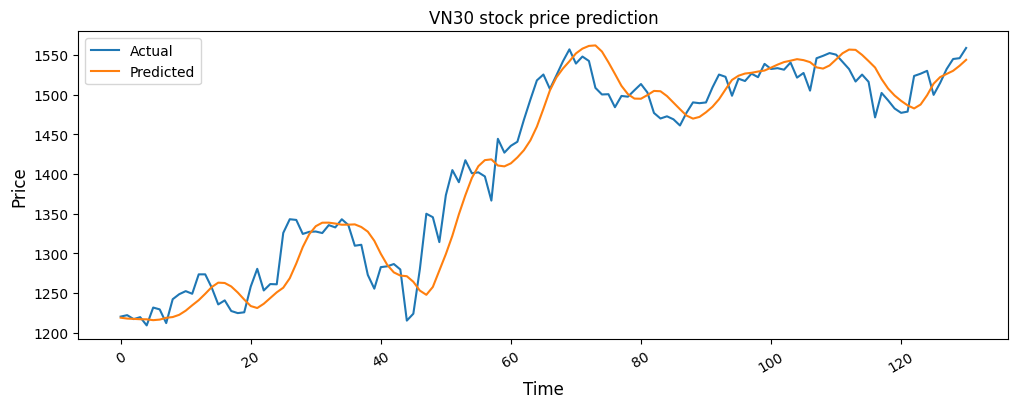

In [315]:
# Evaluate
metrics = calculate_metrics(y_test_, test_predict)
print(f"R-squared: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}, MSPE: {metrics['MSPE']:.6f}, MAPE: {metrics['MAPE']:.2f}%\n")
draw_diagram(y_test_, test_predict)

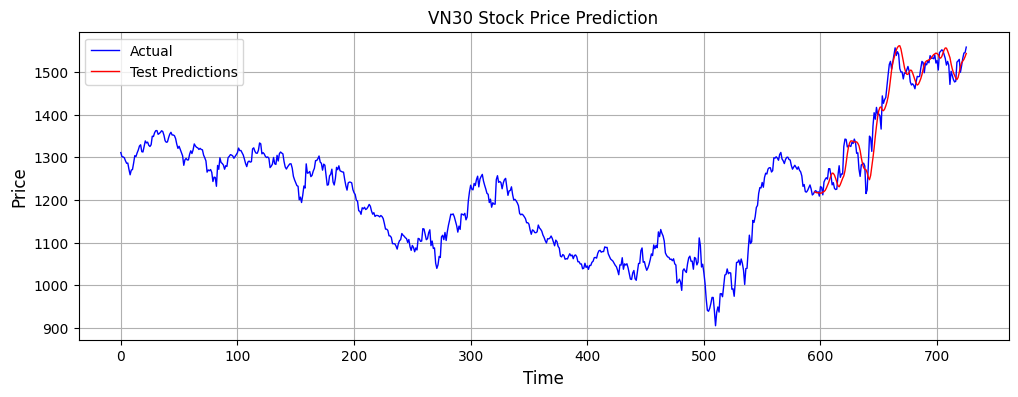

In [316]:
# Visualize Actual on total data and Predictions on test
seq_back = seq_length

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
test_start_idx = len(train_predict) + (seq_back * 2)
testPredictPlot[test_start_idx:test_start_idx + len(test_predict), :] = test_predict

plt.figure(figsize=(12, 4))
plt.plot(data, label='Actual', color='blue', linewidth=1)
plt.plot(testPredictPlot, label='Test Predictions', color='red', linewidth=1)
plt.title("VN30 Stock Price Prediction", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid()
plt.show()


# Load model test

In [317]:
model.save(f"{seq_length}.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
R-squared: 0.9323, RMSE: 30.6650, MSPE: 0.000494, MAPE: 1.67%



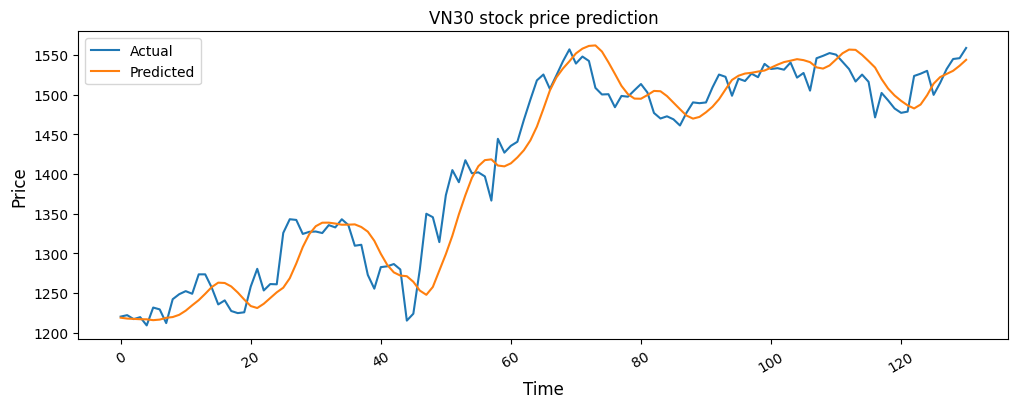

In [319]:
from tensorflow.keras.models import load_model
load = load_model('15.h5')

predict_load = load.predict(X_test)
predict_load = scaler.inverse_transform(predict_load)
load_y = scaler.inverse_transform(y_test)

metrics = calculate_metrics(load_y, predict_load)
print(f"R-squared: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}, MSPE: {metrics['MSPE']:.6f}, MAPE: {metrics['MAPE']:.2f}%\n")
draw_diagram(load_y, predict_load)

# Finding Best Timestep

In [318]:
# # Set list Time step
# seq_lengths = [20, 25, 30, 60]
# results = {}

# for seq_length in seq_lengths:
#     print(f"Experimenting with seq_length = {seq_length}")

#     train_size = int(len(data_scale) * 0.8)
#     test_size = len(data_scale) - train_size
#     train_data, test_data = data_scale[0:train_size, :], data_scale[train_size:len(data_scale), :]


#     X_train, y_train = dataset(train_data, seq_length)
#     X_test, y_test = dataset(test_data, seq_length)

#     model = create_model(64, seq_length)
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)

#     # Evaluate
#     test_predict = model.predict(X_test)
#     test_predict = scaler.inverse_transform(test_predict)
#     y_test_ = scaler.inverse_transform(y_test)

#     metrics = calculate_metrics(y_test_, test_predict)
#     print(f"R-squared: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}, MSPE: {metrics['MSPE']:.6f}, MAPE: {metrics['MAPE']:.2f}%\n")

#     # Store results
#     results[seq_length] = {
#         'R2': metrics['R2'],
#         'RMSE': metrics['RMSE'],
#         'MSPE': metrics['MSPE'],
#         'MAPE': metrics['MAPE'],
#     }

# best_seq_length = min(results.keys(), key=lambda k: results[k]['MAPE'])
# best_metrics = results[best_seq_length]

# print(f"Best seq_length: {best_seq_length}")
# print(f"Best Metrics: R-squared: {best_metrics['R2']:.4f}, MAPE: {best_metrics['MAPE']:.2f}%")